# Enemble Refinement with SAXS data using BioEn

By applying this Jupyter notebook, you can perform ensemble refinement with small-angle X-ray scattering  (SAXS) data using BioEn. The steps of the Jupyer notebook are <br>

1. Preparation of the input <br> 
2. BioEn <br> 
3. Analysis of the BioEn results<br> 

You can either use the provided test data or define your own protein of interest and load your scattering data. The part, which can be individualized by the user, is highlighted in green. 


### Theory and methods applied in this Jupyter notebook are available in:
G. Hummer, J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting,” J. Chem. Phys. 143, 243150 (2015). 


In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pickle
import pandas as pd
import os, h5py, sys, math

import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker

import bioen_scattering as bs

%matplotlib inline

## Define paths to the experimental and simulated data and for the output of preparation, BioEn, and analysis of the BioEn runs

In [2]:
%%capture
! mkdir files/output_preparation
! mkdir files/output_bioen
! mkdir files/output_analysis

# path to experimental data
path_experimental_data = "files/experimental_data/"

# path to simulated data
path_simulated_data = "files/simulated_data/"

# define path to the output of the preparation
path_output_preparation = "files/output_preparation"

# define path to the output of BioEn
path_output_bioen = "files/output_bioen"

# define path to the output of the analysis
path_output_analysis = "files/output_analysis"

# 1. Preparation

In this part of the notebook, we prepare our input for BioEn. The standard output from a scattering experiment is: <br>
    
    #   q                 I(q)        error/noise                                                         
    4.138455E-02        5.904029    1.555333E-01
    4.371607E-02        5.652469    1.527037E-01 
    4.604759E-02        5.533381    1.521723E-01
    4.837912E-02        5.547052    1.474577E-01
    5.071064E-02        5.296281    1.436712E-01
    
For a single modeled structure, predicted scattering intensities will look like this: <br>

	#  q               I(q)
	4.138454e-02 	2.906550e+06
	4.371607e-02 	2.865970e+06
	4.604758e-02 	2.823741e+06
	4.837911e-02 	2.779957e+06
	5.071064e-02 	2.734716e+06

Since these formats are not always available, this notebook also shows how to edit the simulated data, so that ensemble refinement can easily be performed. Therefore, we consider two possible cases.

1. The experimental and simulated data has already the correct format, but the number of data points deviate. However, for the comparison of the experimental and simulated SAXS data, we need the same number of data points in both cases (which might differ using different SAXS data prediction tools). To handle this case of reformating, we interpolate the simulated data for the number of data points provided by the user and save the reformated simulated data in a pkl file, which is subsequently the input for BioEn.
2. We use HDF5 file format as input. This is a convenient file format, while working with a large number of structures. Here, we convert it to a pkl file, as the input for BioEn. *Not yet in the notebook*.

### Reformating SAXS data

In [3]:
# file name of experimental data
fn_exp = "{}/exp-saxs.dat".format(path_experimental_data)

# ids of the models
# here: simple range from 0 to 9 
model_ids = range(0,100)

In [4]:
# get experimental data
exp_1 = np.genfromtxt(fn_exp, comments='#')
exp_tmp = exp_1[:,0:2]

# estimating standard error of the mean 
error = exp_1.copy()
error[:,1] /= error[:,0]
error[:,1] = np.sqrt(error[:,1]) 
exp_err_tmp = exp_1[:,0]

In [5]:
# get number of restraints (M)
nrestraints = len(exp_tmp)

In [6]:
# get simulated data and interpolate (experimental and simulated data have the same number of data points)
sim_tmp = dict()
for nmodel in model_ids:
    fn_sim = "{}/sim-tau{}-test.dat".format(path_simulated_data, nmodel)
    sim_single = np.genfromtxt(fn_sim, comments='#')
    sim_tmp[nmodel] = bs.adapt_q(sim_single, exp_1)[:,1]

In [7]:
# let BioEn perform an initial optimization of the coefficient
coeff = 'initial-optimization'

In [8]:
# write pkl file as input for BioEn
fn_out_pkl = '{}/input-bioen-scattering.pkl'.format(path_output_preparation)
with open(fn_out_pkl, 'wb') as fp:
    pickle.dump([coeff, nrestraints, exp_tmp, exp_err_tmp, sim_tmp], fp)

### Working with HD5F file formats (output from Capriqorn [Köfinger2013])

In [9]:
# needs to be implemented

# BioEn

## Settings and input parameters for BioEn

In [10]:
# define theta series, for which to perform reweighting
theta_series = [10e5, 10e4, 10e3, 10e2, 10e1, 10e0, 10e-1, 0]
np.savetxt('theta.dat', np.array(theta_series))

# number of ensemble members
number_of_ensemble_members = len(model_ids)
np.savetxt('{}/models_scattering.dat'.format(path_output_preparation), model_ids)

In [11]:
#%%capture
! bash run_bioen_ipynb_scattering.sh $number_of_ensemble_members 

INFO:root:BioEn weight refinement starts with
INFO:root:    optimization method: log-weights
INFO:root:    optimization algorithm: bfgs
INFO:root:    optimization minimizer: GSL
INFO:root:BioEn finished weight refinement in 15.41 s.


# Analysis

## Settings and input parameters for analysis of BioEn outputs

In [12]:
# output of BioEn is a pkl file (contains all the necessary information)
bioen_pkl = "{}/bioen-scattering.pkl".format(path_output_bioen)
df = pd.read_pickle(bioen_pkl)
bioen_data = df.to_dict()

`bioen_data` contains all needed and useful information to analyse the BioEn calculations. <br>
For each previously defined confidence value $\theta$ (defined in the variable `theta_series`) a list of variables are available:

**Experimental information**
- **`exp`** <br> 
--> experimental scattering curves<br>
- **`exp_err`** <br>
--> error/noise of each experimental data point defined in `exp`
- **`nrestraints`** <br>
--> number of data points ($M$)

**Simulated data and parameters**
- **`sim_init`** <br> 
--> initial ensemble averaged simulated scattering curves (see above for exp)
- **`sim_wopt`** <br>
--> optimized ensemble averaged simulated scattering curves and for a given confidence value $\theta$
- **`coefficient`** <br>
--> coefficient of the optimized ensemble averaged simulated SAXS data 
- **`nmodels_list`** <br>
--> list of model ids (extracted e.g. from models_370-292.dat)
- **`nmodels`** <br>
--> number of models ($N$), which is also the number of ensemble members (relevant in the BioEn context) <br>


**Free energy parameters**
- **`theta`** <br>
--> confidence parameter $\theta$
- **`chi2_init`** <br>
--> deviation from the experimental data with the initial weight distribution <br>
--> if you use `chi2_init` of the maximal value of $\theta$, $\chi^2$ is calculated with the prior weight distribution `w0`
- **`chi2`** <br>
--> optimal $\chi^2$ calculated with optimal weight distribution `wopt`
- **`S_init`** <br>
--> initial relative entropy
--> if you use `S_init` of the maximal value of $\theta$, $S$ is equal to $0$
- **`S`** <br>
--> relative entropy of optimized weight distribution
- **`w0`** <br>
--> reference weight distribution
- **`winit`** <br>
--> initial weight distribution
- **`wopt`** <br>
--> optimal weight distribution <br>
--> optimized for each $\theta$

**Misc**
- **`len_sim`** <br>
--> seconds it took for BioEn to optimize for a given value of $\theta$
- **`optimization_method`** <br>
--> information about the optimization method: log-weights or forces
- **`optimization_minimizer`** <br>
--> information about the minimer: scipy, GSL, LBFGS
- **`optimization_algorithm`** <br>
--> information about the inimizer: <br>
--> scipy: bfgs, lbfgs, cg <br>
--> GSL: conjugate_fr, conjugate_pr, bfgs, bfgs, steepest_descent<br>
--> LBFGS: lbfgs <br>


Several default plots are provided in the following, so that the analysis is as intuitive as the preparation and running BioEn itself.


### Plot $\chi^{2} vs. S_{\mathrm{KL}}$

the lower $\theta$, the closer to experimental data

In [13]:
def visualize_chi2_skl(bioen_data):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    for theta in theta_series:
        chi2 = bioen_data[theta]['chi2'] / bioen_data[theta]['nrestraints']
        skl = - bioen_data[theta]['S']
        ax.scatter(skl, chi2, marker='^', s=160, label=theta)  
    
    #ax.set_xticks(range(-1,6,1))   
    #ax.set_xticklabels(range(-1,6,1), fontsize=fs)
    #ax.set_xlim(-0.4,5.5)
    ax.set_xlabel(r'$S_{\mathrm{KL}}$', fontsize=fs)

    #ax.set_yticks(np.arange(0,10,1))   
    #ax.set_yticklabels(np.arange(0,10,1), fontsize=fs)
    #ax.set_ylim(-0.2, 4)
    ax.set_ylabel(r'$\chi^{2}$', fontsize=fs)    
    
    plt.grid()
    
    ax.legend(ncol=2, fontsize=10)
    
    plt.tight_layout()
    plt.savefig("{}/bioen_chi2_skl.png".format(path_output_analysis), dpi=400)
    plt.show()
    return

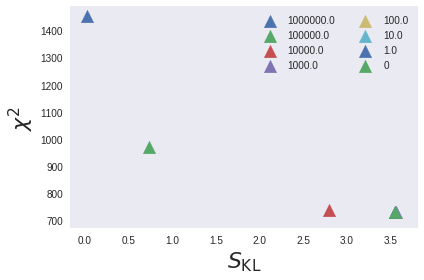

In [14]:
visualize_chi2_skl(bioen_data)

The elbow plot would suggest that a $\theta=100000$ would give good trade-off between agreement with experiment and the initial ensemble.

## Comparison of scattering curves from experiment and ensemble refinement

In [15]:
def visualize_scattering_data(theta, bioen_data):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    theta_max = np.max(bioen_data.keys())
    
    exp = bioen_data[theta]['exp']['scattering']
    exp_err = bioen_data[theta]['exp_err']['scattering']
    
    sim_init = bioen_data[theta_max]['sim_init']['scattering']
    sim = bioen_data[theta]['sim_wopt']['scattering']
    
    ax.plot(exp[:,0], exp[:,1], color='black', linewidth=1.5, label='Exp.',zorder=2)
    ax.fill_between(exp[:,0], exp[:,1]-exp_err, exp[:,1]+exp_err, color='black', alpha=0.2, label='Error', linewidth=1.0, zorder=1)
    ax.plot(exp[:,0], sim_init, color='green', linewidth=2.0, label=r"w0",zorder=0)
    ax.plot(exp[:,0], sim, color='red', linewidth=2.0, label=r"BioEn (wopt)".format(theta),zorder=3)
    
    #ax.set_xticks(np.arange(0,4.0,1.0))
    #ax.set_xticklabels(np.arange(0,4.0,1.0), fontsize=fs)
    #ax.set_xlim(0,3.5)
    ax.set_xlabel(r'q [${\AA}^{-1}$]', fontsize=fs)

    #ax.set_yticks(np.arange(-0.6,1.4,0.2))
    #ax.set_yticklabels(np.arange(-0.6,1.4,0.2), fontsize=fs)
    #ax.set_ylim(0.35,1.0)
    ax.set_ylabel(r'I(q)', fontsize=fs)

    ax.legend(loc=1, ncol=2, fontsize=10)
    
    plt.grid()
    
    plt.tight_layout()
    plt.savefig("{}/bioen_scattering.png".format(path_output_analysis), dpi=400)
    plt.show()
    return

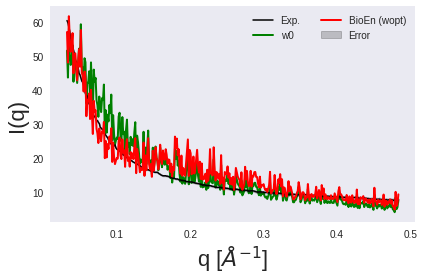

In [16]:
theta = 1.0
visualize_scattering_data(theta, bioen_data)

At $\theta=1$ we find very good agreement. However the elbow plot above highlights large changes in relative entropy for low values of $\theta$. Below we are looking at scattering curves from the optimal ensembles at the different values of $\theta$.

In [17]:
def visualize_scattering_all_thetas(bioen_data):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    theta_max = np.max(bioen_data.keys())
    
    exp = bioen_data[theta_max]['exp']['scattering']
    ax.plot(exp[:,0], exp[:,1], color='black', linewidth=1.5, label='Exp.',zorder=2)
    
    a = np.linspace(0.1, 0.7, num=len(theta_series))
    for i, theta in enumerate(theta_series):
        sim = bioen_data[theta]['sim_wopt']['scattering']
        ax.plot(exp[:,0], sim, color='red', alpha=a[i], linewidth=2.0,
                label=r"BioEn ($\theta={}$)".format(theta), zorder=3)
    
    #ax.set_xticks(np.arange(0,4.0,1.0))
    #ax.set_xticklabels(np.arange(0,4.0,1.0), fontsize=fs)
    #ax.set_xlim(0,3.5)
    ax.set_xlabel(r'q [${\AA}^{-1}$]', fontsize=fs+2)

    #ax.set_yticks(np.arange(-0.6,1.4,0.2))
    #ax.set_yticklabels(np.arange(-0.6,1.4,0.2), fontsize=fs)
    #ax.set_ylim(0.35,1.0)
    ax.set_ylabel(r'I(q)', fontsize=fs)

    ax.legend(loc=1, ncol=2, fontsize=10)
    
    plt.grid()
    
    plt.tight_layout()
    plt.savefig("{}/bioen_theta_series.png".format(path_output_analysis), dpi=400)
    plt.show()
    return

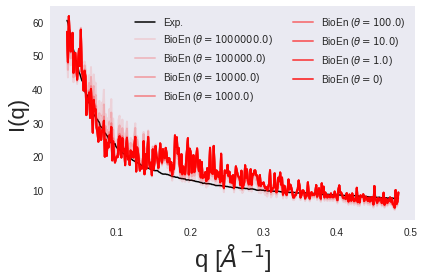

In [18]:
visualize_scattering_all_thetas(bioen_data)

## Cummulative weights

In [21]:
def visualize_cum_dist(theta, bioen_data):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    nmodels = bioen_data[theta]["nmodels"]
    a = np.vstack((bioen_data[theta]["nmodels_list"], np.array(bioen_data[theta]["wopt"]).reshape(1,-1)))
    
    models = []
    for i, id in enumerate(np.argsort(a[1,:])[::-1]):
        if i == 0: models.append([a[:,id][0], float(a[:,id][1]), float(a[:,id][1])])
        else: models.append([a[:,id][0], float(a[:,id][1]), models[-1][2]+float(a[:,id][1])])

    models = np.array(models)
    ax.scatter(range(1,nmodels+1), models[:,2], s=20, color='green', zorder=2)
    ax.plot(range(1,nmodels+1), models[:,2], color='black', zorder=1)

    ax.set_xticks([0.0, 10.0, 100.0, 1000.0, 10000.0])
    ax.set_xticklabels([r'$10^{0}$', r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'], fontsize=fs)
    ax.set_xlabel("Number of configurations", fontsize=fs)
    ax.semilogx()
    ax.set_yticklabels(np.arange(0,1.2,0.2), fontsize=fs)
    ax.set_ylim(0,1)
    ax.set_ylabel("Cumulative distribution", fontsize=fs)
    
    ax.grid()
    
    plt.savefig('{}/bioen_cum_weights.png'.format(path_output_analysis), dpi=600, bbox_inches='tight')
    return

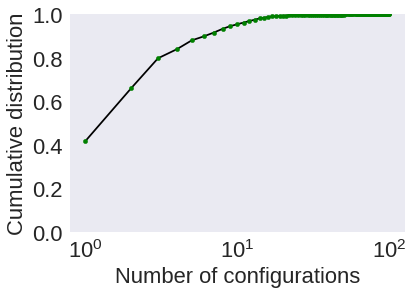

In [25]:
theta = 10000.0
visualize_cum_dist(theta, bioen_data)

At $\theta=10$ about 40% of weight is concentrated in a single structure. This is indicative of overfitting and would suggest to use a larger $\theta$ value. This highlights the importance to look at the distribution of weights before performing further analysis of the optimized BioEn ensembles.

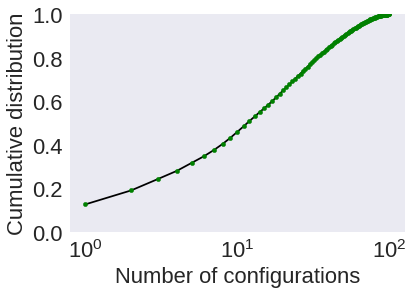

In [52]:
theta = 100000.0
visualize_cum_dist(theta, bioen_data)

At $\theta=100000$ about ten structures out of a 100 structures account for 40% of the weights. This is more reasonable and also agrees with the elbow plot above. 